In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = "/Users/rzhoufias.uni-frankfurt.de/Documents/PhD_Franziska/Headon/Cell tracking tables for figure 1/"

# Dataset of epidermis. 
track_df_epidermis_1 = pd.read_csv(file_path + "Cell cycle chicken video 1 epidermis.tif_Tracking Table full.csv")
track_df_epidermis_2 = pd.read_csv(file_path + "Cell cycle chicken video 2 epidermis.tif_Tracking Table full.csv")
track_df_epidermis_3 = pd.read_csv(file_path + "Cell cycle chicken video 3 epidermis.tif_Tracking Table full.csv")

# Dataset of periderm. 
track_df_periderm_1 = pd.read_csv(file_path + "Fucci Chicken video 1 periderm projection.tif_Tracking Table1 full combined.csv")
track_df_periderm_2 = pd.read_csv(file_path + "Fucci Chicken video 2 periderm projection.tif_Tracking Table1 full results.csv")
track_df_periderm_3 = pd.read_csv(file_path + "Fucci Chicken video 3 periderm projection.tif_Tracking Table full.csv")

# Dataset of dermis. 
track_df_dermis_1 = pd.read_csv(file_path + "UPDATED Cell cycle chicken condensate 1 slice 3.tif_Tracking Table full.csv")
track_df_dermis_2 = pd.read_csv(file_path + "UPDATED Cell cycle chicken condensate 2 slice 3.tif_Tracking Table full.csv")
track_df_dermis_3 = pd.read_csv(file_path + "UPDATED Cell cycle chicken condensate 3 slice 4.tif_Tracking Table full.csv")


In [3]:
# Get the X and Y coordinates with the Track number.

def extract_X_Y_single_track(track_df, track_id):
    # ttrack_df: the dataframe containing track information.
    # track_num: the id of the single track. 
    track_X = track_df.loc[track_df["Track"]==track_id, "X"]
    track_Y = track_df.loc[track_df["Track"]==track_id, "Y"]
    return np.array(track_X), np.array(track_Y)

In [4]:
# The Euclidean distance between strat and end points for each pseudo trajectory.
# Without considering the measure conversion -- in pixel. 

def euclidean_distance_pixel_single_track(x, y):
    # Calculate the Euclidean distance between the start and end points for a single track.
    start_x, end_x = x[0], x[-1]
    start_y, end_y = y[0], y[-1]
    euc_distance = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
    return euc_distance

In [5]:
# Calculate the track length for each pseudo trajectories. 
# Without considering the measure conversion -- in pixel.

def length_pixel_single_track(x, y):
    # Calculate the differences between consecutive points for a single track.
    dx = np.diff(x)
    dy = np.diff(y)
    # Calculate the Euclidean distance for each segment and sum them
    length = np.sum(np.sqrt(dx**2 + dy**2))
    return length

In [6]:
# Calucalte the total time for each track based on the frame numbers.

def total_frame_single_track(track_df, track_id):
    frame_num =  np.sum(np.diff(track_df.loc[track_df["Track"]==track_id, "Frame"]))
    return frame_num

In [7]:
# Calcualte the speed of a single track. 

def speed_single_track(track_df, track_id, time_conversion, pixel_conversion): 

    # Calculate the total time for track. 
    frame_number = total_frame_single_track(track_df, track_id)
    total_time = frame_number * time_conversion

    # Compute the total length of track.
    x, y = extract_X_Y_single_track(track_df, track_id)
    track_length = length_pixel_single_track(x, y)
    # Take account into the measure conversion. Speed = total track length / total time
    track_speed = track_length * pixel_conversion / total_time

    return track_speed

In [8]:
# Calcualate the persistence of a single track. 
# Persistence is calcualted as the euclidean distance / total length of the track.

def persistence_single_track(track_df, track_id): 
    x, y = extract_X_Y_single_track(track_df, track_id)
    # Euclidean distance 
    euc_distance = euclidean_distance_pixel_single_track(x, y)
    # Total length of track 
    length = length_pixel_single_track(x, y)
    # Persistence calculated as euclidean distance / total track length.
    persistence = euc_distance / length
    return persistence

In [9]:
# Add single track information to an existing data frame. 
def add_track_information(exist_dataframe, track_df, time_conversion, pixel_conversion):
    
    # Extract all existing track ids. 
    all_track_id = track_df["Track"].unique()
    # Extract the image name for each dataset table to identify cell tracks. 
    image_id = track_df["Image_ID"][0]

    for i in all_track_id:
        # Calculate the speed.
        speed = speed_single_track(track_df, i, time_conversion, pixel_conversion)
        # Calculate the persistence. 
        persistence = persistence_single_track(track_df, i)
        # Contract the new row that should be add to the existing dataframe. 
        new_row = pd.DataFrame({"Image_ID": [image_id], 
                               "Track_ID": [i],
                               "Speed": [speed], 
                               "Persistence": [persistence]})
        # Add the new row to the existing dataframe. 
        exist_dataframe = pd.concat([exist_dataframe, new_row], ignore_index=True)
        
    return exist_dataframe
    

In [10]:
# Add tge data from a list of dataframe together in one existing dataframe. 

def summary_track_information_in_one_dataframe(df_list, time_conversion, pixel_conversion):
    final_df = pd.DataFrame(columns = ["Image_ID", "Track_ID", "Speed", "Persistence"])
    for df in df_list:
        final_df  = add_track_information(final_df, df, time_conversion, pixel_conversion)
    return final_df

In [11]:
# Dataframe for epidermis. 
epidermis_df_list = [track_df_epidermis_1, track_df_epidermis_2, track_df_epidermis_3]
epidermis_df = summary_track_information_in_one_dataframe(epidermis_df_list, 10, 0.69)

# Dataframe for periderm. 
periderm_df_list = [track_df_periderm_1, track_df_periderm_2, track_df_periderm_3]
periderm_df = summary_track_information_in_one_dataframe(periderm_df_list, 10, 0.69)

# Dataframe for dermis. 
dermis_df_list = [track_df_dermis_1, track_df_dermis_2, track_df_dermis_3]
dermis_df = summary_track_information_in_one_dataframe(dermis_df_list, 10, 0.69)

/var/folders/89/m6q9t4190ll9nwbt7q92wgjr0000gn/T/ipykernel_24605/2208307049.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  exist_dataframe = pd.concat([exist_dataframe, new_row], ignore_index=True)
/var/folders/89/m6q9t4190ll9nwbt7q92wgjr0000gn/T/ipykernel_24605/2208307049.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  exist_dataframe = pd.concat([exist_dataframe, new_row], ignore_index=True)
/var/folders/89/m6q9t4190ll9nwbt7q92wgjr0000gn/T/ipykernel_24605/2208307049.py:20: FutureWar

{'bodies': [<matplotlib.collections.FillBetweenPolyCollection at 0x115f13350>,
 'cmeans': <matplotlib.collections.LineCollection at 0x116128200>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x116210c80>,
 'cmins': <matplotlib.collections.LineCollection at 0x1162116d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x116129f10>}

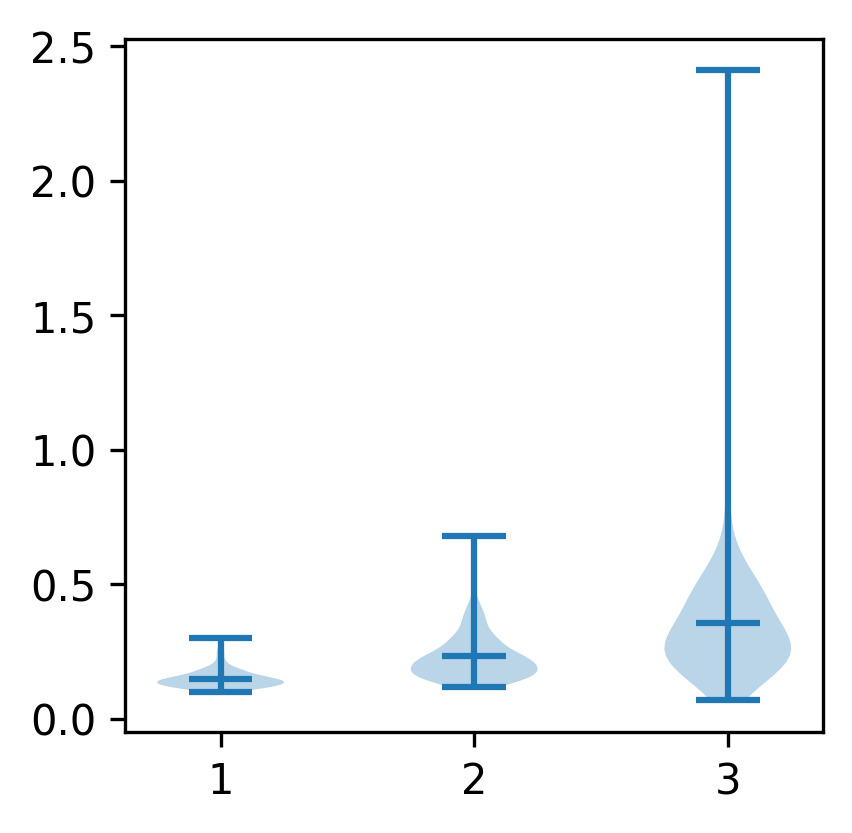

In [12]:
# Plot the speed and persistence data as violin plots, grouped by cell types. 

plt.figure(figsize=(3,3), dpi=300)
plt.violinplot([epidermis_df["Speed"], periderm_df["Speed"], dermis_df["Speed"]], showmeans=True) #, showextrema=False)

# Could try the log of your scale. 
# Add the mean of each single dataset. 

{'bodies': [<matplotlib.collections.FillBetweenPolyCollection at 0x116346ea0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x1120cb560>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1163a7aa0>,
 'cmins': <matplotlib.collections.LineCollection at 0x1163d0a70>,
 'cbars': <matplotlib.collections.LineCollection at 0x1163d1250>}

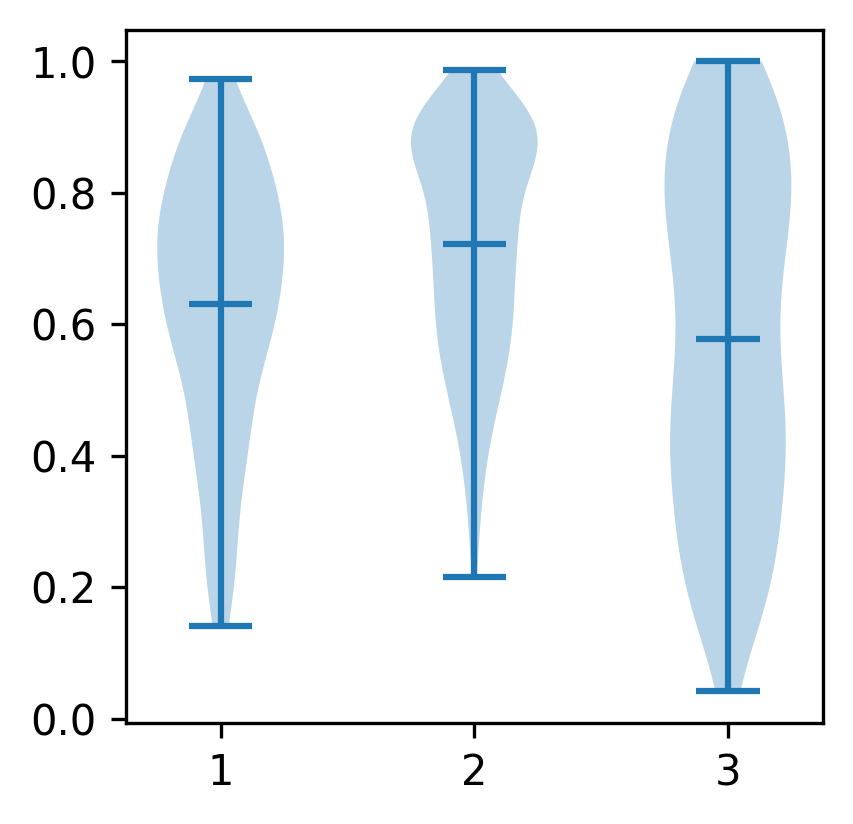

In [13]:
plt.figure(figsize=(3,3), dpi=300)
plt.violinplot([epidermis_df["Persistence"], periderm_df["Persistence"], dermis_df["Persistence"]], showmeans=True) #, showextrema=False)
